#0.Imports

In [ ]:
#all imports
import torch 
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

#1.Preparing fashionMnist dataset

###1.1 Data download

In [ ]:
#setup traning data
traning_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

#setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#lets see all classes
class_to_idx = traning_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

###1.2 Looking at data

In [ ]:
#easier acces to class names, by index
class_names = list(class_to_idx.keys())

Text(0.5, 1.0, 'T-shirt/top')

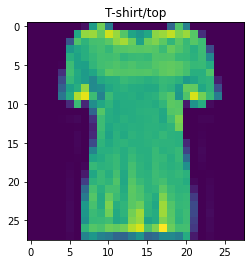

In [ ]:
img_num = 10 #number of image from dataset
img, label = traning_data[img_num]# label is int
plt.imshow(img.squeeze())
plt.title(class_names[label])

(-0.5, 27.5, 27.5, -0.5)

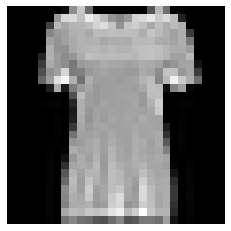

In [ ]:
plt.imshow(img.squeeze(),cmap="gray")
plt.axis(False)

###1.3 Prepering dataloaders

In [ ]:
#dataloader represents a Python iterable over a dataset
#pytorch explanation https://pytorch.org/docs/stable/data.html

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=traning_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

#2.Defining Models

###2.1 Simple model

In [ ]:
#Defines simle model without convolution, just 2 linear layers with relu activation function
class FashionMNISTSimpleModel(nn.Module):
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layers = nn.Sequential(
        
      nn.Flatten(), #flatten inputs
      nn.Linear(in_features=input_shape,out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,out_features=output_shape),
      nn.ReLU()
    )

  def forward(self, x):
    return self.layers(x)

###2.2 CNN model

In [ ]:
#Defines model inspired by CNN explainer website, https://poloclub.github.io/cnn-explainer/
#defines same layers as site above 
class FashionMNISTCnnModel(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
    )
  
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


#3.Train and test loop

###3.1 Train loop

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):

  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X,y) in enumerate(data_loader):
    model.train()
    X,y = X.to(device), y.to(device) #moving data do device

    #forwardpass
    y_pred = model(X)

    #calcuate the loss(per batch)

    loss = loss_fn(y_pred,y)
    train_loss += loss #accumulate train loss
    train_acc += accuracy_fn(y,y_pred.argmax(dim=1)) #from logits to prediction labels



    optimizer.zero_grad() # zero grad

    loss.backward() #bachprogagation

    optimizer.step() #update params

  #devide totoal train loss by len of train dataloader

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

###3.2 Test loop

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  

  test_loss, test_acc = 0, 0

  model.eval() #move model to evaluation mode

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)#moves data to device

      test_pred = model(X) #predicting model outoput/forward pass

      #calculating lost and accuracy
      test_loss += loss_fn(test_pred,y)

      test_acc += accuracy_fn(y,test_pred.argmax(dim=1))
    
    
    test_loss /= len(data_loader)

    #calcuate the test acc acerage per batch

    test_acc /= len(data_loader)

    print(f"\nTest loss {test_loss:.2f} | Test acc: {test_acc:.2f}")

#4.Models evaluation

In [ ]:
#setting device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Calculate accuracy between truth labels and predictions
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

###4.1 Simple linear model

In [ ]:
torch.manual_seed(42) #setting seed, optional

simple_model = FashionMNISTSimpleModel(784,10,10).to(device) # send model to gpu if available

loss_fn = nn.CrossEntropyLoss()#loss function

optimizer = torch.optim.SGD(params=simple_model.parameters(), lr=0.1) # optimizer

epochs = 10

#optimization and evaluation loop

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(simple_model,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)
  test_step(simple_model,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------

Test loss 1.00 | Test acc: 64.13
Epoch: 1
---------

Test loss 0.91 | Test acc: 66.86
Epoch: 2
---------

Test loss 0.89 | Test acc: 66.46
Epoch: 3
---------

Test loss 0.91 | Test acc: 66.34
Epoch: 4
---------

Test loss 0.87 | Test acc: 67.33
Epoch: 5
---------

Test loss 0.89 | Test acc: 66.85
Epoch: 6
---------

Test loss 0.88 | Test acc: 66.53
Epoch: 7
---------

Test loss 0.86 | Test acc: 67.85
Epoch: 8
---------

Test loss 0.68 | Test acc: 75.18
Epoch: 9
---------

Test loss 0.70 | Test acc: 74.86


###4.2 CNN model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

cnn_model = FashionMNISTCnnModel(input_shape=1,
                              hidden_units=10,
                              output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),lr=0.1)


epochs = 10
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  train_step(cnn_model,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device=device)
  test_step(cnn_model,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-----

Test loss 0.39 | Test acc: 85.84
Epoch: 1
-----

Test loss 0.36 | Test acc: 86.48
Epoch: 2
-----

Test loss 0.33 | Test acc: 88.08
Epoch: 3
-----

Test loss 0.31 | Test acc: 88.44
Epoch: 4
-----

Test loss 0.32 | Test acc: 88.63
Epoch: 5
-----

Test loss 0.29 | Test acc: 89.51
Epoch: 6
-----

Test loss 0.32 | Test acc: 88.34
Epoch: 7
-----

Test loss 0.30 | Test acc: 89.27
Epoch: 8
-----

Test loss 0.28 | Test acc: 89.46
Epoch: 9
-----

Test loss 0.28 | Test acc: 89.84
